In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import catboost as cb
import warnings
warnings.filterwarnings('ignore')


### 1. Carregamento e Exploração Inicial dos Dados

In [54]:
df = pd.read_csv('smart_home_energy_usage_dataset.csv', parse_dates=['timestamp'])

In [ ]:

print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())


            timestamp  home_id  energy_consumption_kWh  temperature_setting_C  \
0 2023-01-01 00:00:00       44                    2.87                   22.1   
1 2023-01-01 01:00:00       81                    0.56                   15.4   
2 2023-01-01 02:00:00       94                    4.49                   22.4   
3 2023-01-01 03:00:00       20                    2.13                   24.6   
4 2023-01-01 04:00:00        3                    2.74                   21.4   

  occupancy_status     appliance  usage_duration_minutes  season day_of_week  \
0         Occupied  Refrigerator                     111  Spring      Sunday   
1         Occupied          HVAC                     103  Summer      Sunday   
2         Occupied   Electronics                      12  Autumn      Sunday   
3       Unoccupied    Dishwasher                      54  Autumn      Sunday   
4       Unoccupied          HVAC                       6  Summer      Sunday   

   holiday  
0        0  
1     

### 3. Análise das Variáveis Categóricas
##### Examinei a distribuição das categorias nas colunas categóricas para entender a composição dos dados.

In [ ]:
categorical_cols = ['season', 'day_of_week', 'occupancy_status', 'appliance']
for col in categorical_cols:
    print(f"Coluna: {col}")
    print(df[col].value_counts())
    print("\n")


Coluna: season
season
Autumn    250372
Summer    250046
Winter    250023
Spring    249559
Name: count, dtype: int64


Coluna: day_of_week
day_of_week
Sunday       142872
Monday       142872
Tuesday      142864
Wednesday    142848
Thursday     142848
Friday       142848
Saturday     142848
Name: count, dtype: int64


Coluna: occupancy_status
occupancy_status
Occupied      500394
Unoccupied    499606
Name: count, dtype: int64


Coluna: appliance
appliance
Lighting           167310
Refrigerator       166804
Electronics        166638
Dishwasher         166629
Washing Machine    166378
HVAC               166241
Name: count, dtype: int64




### 4. Visualização dos Dados
#### Algumas visualizações para entender a distribuição de kWh.


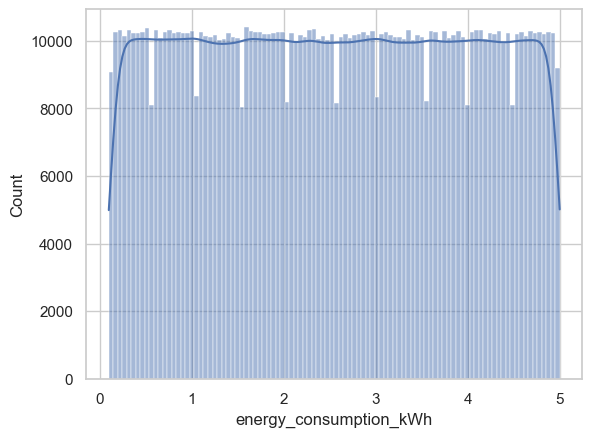

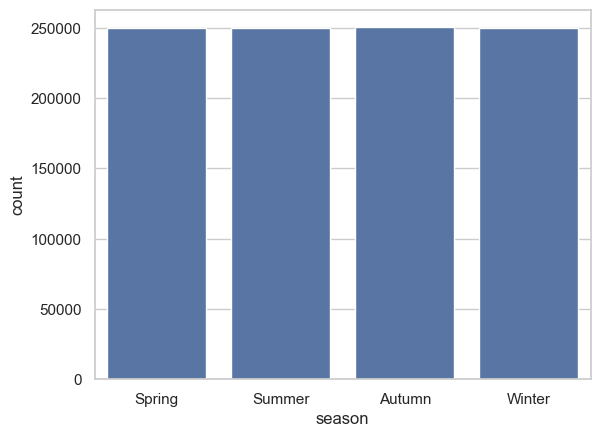

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(df['energy_consumption_kWh'], kde=True)
plt.show()
sns.countplot(data=df, x='season')
plt.show()


### 5. Engenharia de Features Temporais
##### Extraí algumas informações temporais da coluna timestamp para criar novas features que possam influenciar o consumo de energia.

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['day_of_year'] = df['timestamp'].dt.dayofyear
df['week_of_year'] = df['timestamp'].dt.isocalendar().week
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)



### 6. Codificação de Variáveis Categóricas
##### Convertendo variáveis categóricas em numéricas utilizando One-Hot Encoding para que possam ser utilizadas pelos modelos Random Forest.

In [ ]:

categorical_cols = ['season', 'day_of_week', 'occupancy_status', 'appliance']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(df.head())


            timestamp  home_id  energy_consumption_kWh  temperature_setting_C  \
0 2023-01-01 00:00:00       44                    2.87                   22.1   
1 2023-01-01 01:00:00       81                    0.56                   15.4   
2 2023-01-01 02:00:00       94                    4.49                   22.4   
3 2023-01-01 03:00:00       20                    2.13                   24.6   
4 2023-01-01 04:00:00        3                    2.74                   21.4   

   usage_duration_minutes  holiday  hour  day  month  day_of_year  ...  \
0                     111        0     0    1      1            1  ...   
1                     103        0     1    1      1            1  ...   
2                      12        0     2    1      1            1  ...   
3                      54        0     3    1      1            1  ...   
4                       6        0     4    1      1            1  ...   

   day_of_week_Sunday  day_of_week_Thursday  day_of_week_Tuesday  \


### 7. Normalização das Features Numéricas
##### Apiquei a normalização nas colunas numéricas para garantir que todas as features estejam na mesma escala, o que talvez melhore o desempenho dos modelos.

In [ ]:

numeric_cols = ['home_id', 'usage_duration_minutes',
               'hour', 'day', 'month', 'day_of_year', 'week_of_year']

scaler = StandardScaler()

df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print(df.head())


            timestamp   home_id  energy_consumption_kWh  \
0 2023-01-01 00:00:00 -0.210445                    2.87   
1 2023-01-01 01:00:00  1.083029                    0.56   
2 2023-01-01 02:00:00  1.537492                    4.49   
3 2023-01-01 03:00:00 -1.049455                    2.13   
4 2023-01-01 04:00:00 -1.643754                    2.74   

   temperature_setting_C  usage_duration_minutes  holiday      hour      day  \
0                   22.1                1.486064        0 -1.661318 -1.67379   
1                   15.4                1.255197        0 -1.516855 -1.67379   
2                   22.4               -1.370924        0 -1.372392 -1.67379   
3                   24.6               -0.158868        0 -1.227929 -1.67379   
4                   21.4               -1.544075        0 -1.083465 -1.67379   

      month  day_of_year  ...  day_of_week_Sunday  day_of_week_Thursday  \
0 -1.599512    -1.725291  ...                True                 False   
1 -1.599512   

### 8. Remoção da Coluna 'timestamp'
#### Após a extração das features temporais, removi a coluna timestamp para evitar conflitos durante o treinamento do modelo.

In [ ]:
df = df.drop('timestamp', axis=1)
print('timestamp' in df.columns)  


False


### 9. Conversão de Colunas Booleanas para Inteiros
##### Converti as colunas booleanas para inteiros pra compatibilidade com o modelo

In [ ]:
bool_cols = df.select_dtypes(include=['bool']).columns
print("Colunas booleanas antes da conversão:", bool_cols)


df[bool_cols] = df[bool_cols].astype(int)


print(df[bool_cols].head())
print(df.dtypes)


Colunas booleanas antes da conversão: Index(['season_Spring', 'season_Summer', 'season_Winter', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'occupancy_status_Unoccupied', 'appliance_Electronics',
       'appliance_HVAC', 'appliance_Lighting', 'appliance_Refrigerator',
       'appliance_Washing Machine'],
      dtype='object')
   season_Spring  season_Summer  season_Winter  day_of_week_Monday  \
0              1              0              0                   0   
1              0              1              0                   0   
2              0              0              0                   0   
3              0              0              0                   0   
4              0              1              0                   0   

   day_of_week_Saturday  day_of_week_Sunday  day_of_week_Thursday  \
0                     0                   1                     0

### 10. Preparação dos Dados para o Treinamento
##### Defini as variáveis de entrada e a variável alvo, e dividi os dados em conjuntos de treinamento e teste mantendo a ordem temporal.

In [ ]:
df = df.sort_values(by=['month', 'day', 'hour'])
X = df.drop(['energy_consumption_kWh'], axis=1)
y = df['energy_consumption_kWh']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")


Treino: (800000, 25), Teste: (200000, 25)


### 11. Verificação Final das Features
#### Apenas garantindo que está tudo certo!

In [ ]:

print(df.dtypes)


non_numeric_cols = df.select_dtypes(include=['object', 'datetime']).columns
print("Colunas não numéricas:", non_numeric_cols)


if len(non_numeric_cols) > 0:
    print("Trate as colunas não numéricas antes de treinar o modelo.")
else:
    print("Todas as colunas são numéricas.")


home_id                        float64
energy_consumption_kWh         float64
temperature_setting_C          float64
usage_duration_minutes         float64
holiday                          int64
hour                           float64
day                            float64
month                          float64
day_of_year                    float64
week_of_year                   float64
is_weekend                       int32
season_Spring                    int32
season_Summer                    int32
season_Winter                    int32
day_of_week_Monday               int32
day_of_week_Saturday             int32
day_of_week_Sunday               int32
day_of_week_Thursday             int32
day_of_week_Tuesday              int32
day_of_week_Wednesday            int32
occupancy_status_Unoccupied      int32
appliance_Electronics            int32
appliance_HVAC                   int32
appliance_Lighting               int32
appliance_Refrigerator           int32
appliance_Washing Machine

### 12. Definição da Função de Avaliação do Modelo
##### Criamos uma função para avaliar o desempenho dos modelos utilizando métricas como MAE, RMSE e R².

In [65]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return mae, rmse, r2


### 13. Treinamento e Avaliação do Modelo Random Forest Regressor
#### Treinamos o modelo Random Forest e avaliamos seu desempenho.

In [66]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_mae, rf_rmse, rf_r2 = evaluate_model(rf, X_train, y_train, X_test, y_test)
print(f"Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}, R2: {rf_r2}")

Random Forest - MAE: 1.229448274, RMSE: 1.4247304906518636, R2: -0.018589069632203303


O modelo Random Forest Regressor foi utilizado para prever o consumo de energia em residências inteligentes. As métricas obtidas foram:

MAE (Mean Absolute Error): 1.23 kWh, indicando que, em média, o erro absoluto das previsões é de aproximadamente 1.23 kWh em relação ao consumo real.  
RMSE (Root Mean Squared Error): 1.42 kWh, revelando que o modelo comete erros ligeiramente maiores em alguns casos, já que o RMSE penaliza mais erros altos.  
R² (Coeficiente de Determinação): -0.0186, mostrando que o modelo tem performance inferior a uma previsão baseada na média dos valores reais.  
Esses resultados indicam que o modelo ainda não conseguiu capturar bem os padrões do consumo de energia. Para melhorar, é necessário ajustar os hiperparâmetros, criar novas variáveis explicativas (como agregações temporais e dados climáticos) ou experimentar outros modelos.